### The German Traffic Sign Benchmark

Student Name 1: Matteo Anelli

Student Name 2: José Manuel Pérez

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [0]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-01 10:55:23--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  3.58MB/s    in 4m 59s  

2019-04-01 11:00:22 (5.31 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (56, 56)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

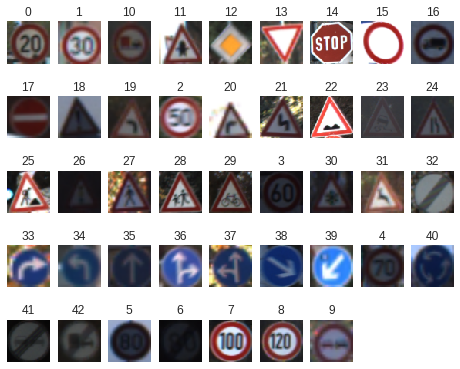

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop

cnn = Sequential()

cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(4, 4), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(4, 4), padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(4, 4), padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(4, 4), padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(num_classes, activation = 'softmax'))

opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=0.0000001, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_437 (Conv2D)          (None, 56, 56, 32)        1568      
_________________________________________________________________
max_pooling2d_436 (MaxPoolin (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_438 (Conv2D)          (None, 28, 28, 64)        32832     
_________________________________________________________________
max_pooling2d_437 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_439 (Conv2D)          (None, 14, 14, 128)       131200    
_________________________________________________________________
max_pooling2d_438 (MaxPoolin (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_440 (Conv2D)          (None, 7, 7, 32)          65568     
__________

In [0]:
data = cnn.fit(tr_signs, tr_labels, batch_size=8, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/100
 - 6s - loss: 3.6943 - acc: 0.0467 - val_loss: 3.5563 - val_acc: 0.1468
Epoch 2/100
 - 1s - loss: 3.5929 - acc: 0.0867 - val_loss: 3.2887 - val_acc: 0.1905
Epoch 3/100
 - 1s - loss: 3.2902 - acc: 0.1733 - val_loss: 3.0211 - val_acc: 0.2460
Epoch 4/100
 - 1s - loss: 2.9617 - acc: 0.2683 - val_loss: 2.6776 - val_acc: 0.3413
Epoch 5/100
 - 1s - loss: 2.6435 - acc: 0.3283 - val_loss: 2.5202 - val_acc: 0.3889
Epoch 6/100
 - 1s - loss: 2.4304 - acc: 0.3567 - val_loss: 2.3436 - val_acc: 0.4087
Epoch 7/100
 - 1s - loss: 2.2584 - acc: 0.4217 - val_loss: 2.3317 - val_acc: 0.4127
Epoch 8/100
 - 1s - loss: 2.0334 - acc: 0.4383 - val_loss: 1.9371 - val_acc: 0.5119
Epoch 9/100
 - 1s - loss: 1.8568 - acc: 0.4717 - val_loss: 1.7599 - val_acc: 0.5317
Epoch 10/100
 - 1s - loss: 1.6359 - acc: 0.5350 - val_loss: 1.7433 - val_acc: 0.5119
Epoch 11/100
 - 1s - loss: 1.4943 - acc: 0.5583 - val_loss: 1.5955 - val_acc: 0.5357
Epoch 12/100
 - 1s - loss: 1

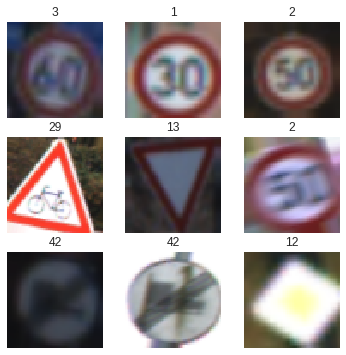

Epoch 1/100
 - 6s - loss: 3.7064 - acc: 0.0304 - val_loss: 3.6951 - val_acc: 0.0198
Epoch 2/100
 - 1s - loss: 3.6693 - acc: 0.0439 - val_loss: 3.6322 - val_acc: 0.0794
Epoch 3/100
 - 1s - loss: 3.6027 - acc: 0.0980 - val_loss: 3.5254 - val_acc: 0.1349
Epoch 4/100
 - 1s - loss: 3.4808 - acc: 0.1351 - val_loss: 3.3273 - val_acc: 0.2143
Epoch 5/100
 - 1s - loss: 3.2250 - acc: 0.1824 - val_loss: 3.0915 - val_acc: 0.2063
Epoch 6/100
 - 1s - loss: 3.0826 - acc: 0.1824 - val_loss: 2.7667 - val_acc: 0.3095
Epoch 7/100
 - 1s - loss: 2.6960 - acc: 0.3108 - val_loss: 2.5703 - val_acc: 0.2976
Epoch 8/100
 - 1s - loss: 2.8729 - acc: 0.2230 - val_loss: 2.5713 - val_acc: 0.3056
Epoch 9/100
 - 1s - loss: 2.5621 - acc: 0.3041 - val_loss: 2.5361 - val_acc: 0.3413
Epoch 10/100
 - 1s - loss: 2.4898 - acc: 0.3514 - val_loss: 2.2804 - val_acc: 0.3492
Epoch 11/100
 - 1s - loss: 2.3695 - acc: 0.3311 - val_loss: 2.1477 - val_acc: 0.4048
Epoch 12/100
 - 1s - loss: 2.2224 - acc: 0.3851 - val_loss: 2.0922 - val_a

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator
    rotation_range=15,
    zoom_range=0.1,
    fill_mode='nearest')
    
  
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=8), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))